In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import missingno as msno

data_path = '../../../data/'

In [8]:
train = pd.read_csv(data_path + 'train.csv')
train.head(), train.tail()

(                    ID  target
 0  2023-01-01 00:00:00       2
 1  2023-01-01 01:00:00       1
 2  2023-01-01 02:00:00       1
 3  2023-01-01 03:00:00       1
 4  2023-01-01 04:00:00       2,
                        ID  target
 8755  2023-12-31 19:00:00       1
 8756  2023-12-31 20:00:00       1
 8757  2023-12-31 21:00:00       0
 8758  2023-12-31 22:00:00       2
 8759  2023-12-31 23:00:00       2)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      8760 non-null   object
 1   target  8760 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 137.0+ KB


In [9]:
test = pd.read_csv(data_path + 'test.csv')
test.head(), test.tail()

(                    ID
 0  2024-01-01 00:00:00
 1  2024-01-01 01:00:00
 2  2024-01-01 02:00:00
 3  2024-01-01 03:00:00
 4  2024-01-01 04:00:00,
                        ID
 2787  2024-04-26 03:00:00
 2788  2024-04-26 04:00:00
 2789  2024-04-26 05:00:00
 2790  2024-04-26 06:00:00
 2791  2024-04-26 07:00:00)

In [80]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2792 non-null   object
dtypes: object(1)
memory usage: 21.9+ KB


### inference 할 범위는 2024 01 01 부터 2024 04 26 07시 까지,
### 필요한 데이터의 범위는 2023 01 01 부터 2024 04 26 07시

In [10]:
price = pd.read_csv(data_path + 'HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD.csv')
price.head(), price.tail()

(              datetime         close       volume
 0  2023-01-01 00:00:00  16536.747967  5516.420322
 1  2023-01-01 01:00:00  16557.136536  4513.341881
 2  2023-01-01 02:00:00  16548.149805  4310.904314
 3  2023-01-01 03:00:00  16533.632875  4893.417864
 4  2023-01-01 04:00:00  16524.712159  5209.002297,
                  datetime         close       volume
 8755  2023-12-31 19:00:00  42597.709522  1002.251559
 8756  2023-12-31 20:00:00  42535.570787  1070.042124
 8757  2023-12-31 21:00:00  42497.523419  1026.473547
 8758  2023-12-31 22:00:00  42257.026218  1715.192245
 8759  2023-12-31 23:00:00  42285.799905  1549.917518)

In [11]:
liquid = pd.read_csv(data_path + 'HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL.csv')
liquid.head()

,datetime,long_liquidations,short_liquidations,long_liquidations_usd,short_liquidations_usd
0,2024-04-26 11:00:00,0.008974,0.052000,572.75910,3347.15338
1,2024-04-26 10:00:00,9.029485,0.015000,577355.85989,970.12692
2,2024-04-26 09:00:00,0.646000,1.530479,41461.23896,98975.62471
3,2024-04-26 08:00:00,0.483000,0.261000,30903.30038,16855.20633
4,2024-04-26 07:00:00,2.360383,3.930057,151151.38884,253858.89276


In [12]:
interest = pd.read_csv(data_path + 'HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL.csv')
interest.head()

,datetime,open_interest
0,2024-04-26 03:00:00,1.486836e+10
1,2024-04-26 02:00:00,1.489030e+10
2,2024-04-26 01:00:00,1.481352e+10
3,2024-04-26 00:00:00,1.475586e+10
4,2024-04-25 23:00:00,1.477917e+10


In [13]:
rate = pd.read_csv(data_path + 'HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE.csv')
rate.head()

,datetime,funding_rates
0,2024-04-25 00:00:00,0.009411
1,2024-04-24 23:00:00,0.009148
2,2024-04-24 22:00:00,0.009161
3,2024-04-24 21:00:00,0.008735
4,2024-04-24 20:00:00,0.007682


### Open interest, Funding rates는 4월 26일 7시까지의 데이터가 불충분 -> 결측치 처리 필요

In [14]:
premium = pd.read_csv(data_path + 'HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv')
premium.head()

,datetime,coinbase_premium_gap,coinbase_premium_index
0,2024-04-26 06:00:00,-2.05,-0.003184
1,2024-04-26 05:00:00,1.85,0.002866
2,2024-04-26 04:00:00,-11.73,-0.018268
3,2024-04-26 03:00:00,-1.53,-0.002376
4,2024-04-26 02:00:00,2.70,0.004186


In [15]:


# HOURLY_NETWORK 로 시작하는 .csv 파일 이름을 file_names 에 할당
file_names = [f for f in os.listdir(data_path) if f.startswith('HOURLY_NETWORK')]
file_names

['HOURLY_NETWORK-DATA_VELOCITY.csv',
 'HOURLY_NETWORK-DATA_UTXO-COUNT.csv',
 'HOURLY_NETWORK-DATA_DIFFICULTY.csv',
 'HOURLY_NETWORK-DATA_FEES.csv',
 'HOURLY_NETWORK-DATA_TOKENS-TRANSFERRED.csv',
 'HOURLY_NETWORK-DATA_TRANSACTIONS-COUNT.csv',
 'HOURLY_NETWORK-DATA_FEES-TRANSACTION.csv',
 'HOURLY_NETWORK-DATA_BLOCK-COUNT.csv',
 'HOURLY_NETWORK-DATA_SUPPLY.csv',
 'HOURLY_NETWORK-DATA_HASHRATE.csv',
 'HOURLY_NETWORK-DATA_BLOCKREWARD.csv',
 'HOURLY_NETWORK-DATA_ADDRESSES-COUNT.csv',
 'HOURLY_NETWORK-DATA_BLOCK-INTERVAL.csv',
 'HOURLY_NETWORK-DATA_BLOCK-BYTES.csv']

In [33]:
# 네트워크 데이터 중 끝나는 시각이 04 26 07시 인 데이터를 merge할 기준 데이터로 선정
network = pd.read_csv(os.path.join(data_path, file_names[0]))
network.head()

,datetime,velocity_supply_total
0,2024-04-26 07:00:00,15.710484
1,2024-04-26 06:00:00,15.710891
2,2024-04-26 05:00:00,15.709207
3,2024-04-26 04:00:00,15.709585
4,2024-04-26 03:00:00,15.708903


In [34]:

for file_name in file_names:
    temp = pd.read_csv(os.path.join(data_path, file_name))
    network = network.merge(temp, on='datetime', how='left')
network.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115021 entries, 0 to 115020
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   datetime                     115021 non-null  object 
 1   velocity_supply_total_x      115021 non-null  float64
 2   velocity_supply_total_y      115021 non-null  float64
 3   utxo_count                   112438 non-null  float64
 4   difficulty                   114764 non-null  float64
 5   fees_block_mean              114764 non-null  float64
 6   fees_block_mean_usd          114764 non-null  float64
 7   fees_total                   115021 non-null  float64
 8   fees_total_usd               115021 non-null  float64
 9   fees_reward_percent          114764 non-null  float64
 10  tokens_transferred_total     115021 non-null  float64
 11  tokens_transferred_mean      114760 non-null  float64
 12  tokens_transferred_median    115021 non-null  float64
 13 

In [35]:
network.head()

,datetime,velocity_supply_total_x,velocity_supply_total_y,utxo_count,difficulty,fees_block_mean,fees_block_mean_usd,fees_total,fees_total_usd,fees_reward_percent,...,supply_total,supply_new,hashrate,blockreward,blockreward_usd,addresses_count_active,addresses_count_sender,addresses_count_receiver,block_interval,block_bytes
0,2024-04-26 07:00:00,15.710484,15.710484,NaN,8.810419e+13,0.845135,54431.281324,2.535404,163293.843971,0.212873,...,NaN,NaN,3.153372e+11,11.910404,7.670859e+05,31851,18649,16054,1413.666667,NaN
1,2024-04-26 06:00:00,15.710891,15.710891,179852452.0,8.810419e+13,0.485483,31287.539460,1.941932,125150.157841,0.134465,...,NaN,NaN,4.204496e+11,14.441932,9.307435e+05,36270,26186,12668,501.000000,NaN
2,2024-04-26 05:00:00,15.709207,15.709207,179851249.0,8.810419e+13,0.625348,40213.804000,3.752089,241282.824002,0.166744,...,NaN,NaN,6.306744e+11,22.502089,1.447081e+06,51858,34083,22094,658.000000,NaN
3,2024-04-26 04:00:00,15.709585,15.709585,179833897.0,8.810419e+13,0.674233,43369.993511,4.045398,260219.961065,0.177466,...,NaN,NaN,6.306744e+11,22.795398,1.466257e+06,56580,31320,29096,697.333333,NaN
4,2024-04-26 03:00:00,15.708903,15.708903,179820708.0,8.810419e+13,0.779972,50242.893436,2.339916,150728.680308,0.199738,...,NaN,NaN,3.153372e+11,11.714916,7.545328e+05,29250,18154,13601,895.000000,NaN


In [36]:
network = network.iloc[:11552, :]
network

,datetime,velocity_supply_total_x,velocity_supply_total_y,utxo_count,difficulty,fees_block_mean,fees_block_mean_usd,fees_total,fees_total_usd,fees_reward_percent,...,supply_total,supply_new,hashrate,blockreward,blockreward_usd,addresses_count_active,addresses_count_sender,addresses_count_receiver,block_interval,block_bytes
0,2024-04-26 07:00:00,15.710484,15.710484,NaN,8.810419e+13,0.845135,54431.281324,2.535404,163293.843971,0.212873,...,NaN,NaN,3.153372e+11,11.910404,7.670859e+05,31851,18649,16054,1413.666667,NaN
1,2024-04-26 06:00:00,15.710891,15.710891,179852452.0,8.810419e+13,0.485483,31287.539460,1.941932,125150.157841,0.134465,...,NaN,NaN,4.204496e+11,14.441932,9.307435e+05,36270,26186,12668,501.000000,NaN
2,2024-04-26 05:00:00,15.709207,15.709207,179851249.0,8.810419e+13,0.625348,40213.804000,3.752089,241282.824002,0.166744,...,NaN,NaN,6.306744e+11,22.502089,1.447081e+06,51858,34083,22094,658.000000,NaN
3,2024-04-26 04:00:00,15.709585,15.709585,179833897.0,8.810419e+13,0.674233,43369.993511,4.045398,260219.961065,0.177466,...,NaN,NaN,6.306744e+11,22.795398,1.466257e+06,56580,31320,29096,697.333333,NaN
4,2024-04-26 03:00:00,15.708903,15.708903,179820708.0,8.810419e+13,0.779972,50242.893436,2.339916,150728.680308,0.199738,...,NaN,NaN,3.153372e+11,11.714916,7.545328e+05,29250,18154,13601,895.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2023-01-01 04:00:00,65.969825,65.969825,83339168.0,3.536407e+13,0.049267,814.168153,0.344866,5699.177070,0.007821,...,1.924886e+07,43.75,2.953368e+11,44.094866,7.286038e+05,45176,17320,31712,703.000000,712739.000000
11548,2023-01-01 03:00:00,65.975092,65.975092,83326258.0,3.536407e+13,0.043966,726.437226,0.219829,3632.186132,0.006985,...,1.924882e+07,31.25,2.109549e+11,31.469829,5.199754e+05,32717,11421,23799,667.800000,640371.800000
11549,2023-01-01 02:00:00,65.975570,65.975570,83314090.0,3.536407e+13,0.039122,647.076754,0.312978,5176.614029,0.006221,...,1.924879e+07,50.00,3.375278e+11,50.312978,8.321735e+05,33897,17737,19369,365.125000,558209.750000
11550,2023-01-01 01:00:00,65.977755,65.977755,83314883.0,3.536407e+13,0.064062,1059.273848,0.256248,4237.095391,0.010146,...,1.924874e+07,25.00,1.687639e+11,25.256248,4.176322e+05,30593,12342,20534,782.500000,890760.500000


### 대충 네트워크 데이터를 한 테이블에 모으고 2023 01 01 부터 2024 04 26 07시로 정돈

In [37]:
# 결측치 개수 계산
missing_counts = network.isnull().sum().sort_values(ascending=False)

# 결측치가 있는 컬럼만 선택 (개수가 0보다 큰 경우)
missing_columns = missing_counts[missing_counts > 0]

# 결과 출력
print("결측치 개수 (컬럼별):")
print(missing_columns)

결측치 개수 (컬럼별):
block_bytes                  54
transactions_count_mean      28
supply_new                   28
supply_total                 28
difficulty                   24
fees_block_mean              24
fees_reward_percent          24
block_interval               24
fees_transaction_mean        24
fees_transaction_mean_usd    24
fees_block_mean_usd          24
tokens_transferred_mean      24
block_count                   4
transactions_count_total      4
utxo_count                    1
dtype: int64


## price에 대한 단변량 분석과 다변량 분석

In [9]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  8760 non-null   object 
 1   close     8760 non-null   float64
 2   volume    8760 non-null   float64
dtypes: float64(2), object(1)
memory usage: 205.4+ KB


In [10]:
price.describe()

,close,volume
count,8760.000000,8760.000000
mean,28797.311293,5068.806648
std,5885.741786,7614.047475
min,16519.005107,116.496744
25%,25927.520671,1005.763158
50%,27698.872221,2080.778155
75%,30241.233602,6001.937086
max,44537.263059,106106.465006


## close와 volume의 통계량
close의 경우엔 mean과 50%가 비슷하고 std 경우도 너무 크지 않게 나온다,
밑의 plot을 놓고 봐도 점진적으로 증가한 그래프에 대한 통계량에 대한 기대와 일치한다고 보인다?

volume의 경우는 mean과 50%가 큰 차이를 보인다, 데이터가 중위값 보다 위쪽에 많이 몰려있거나 이상치가 위쪽에 많이 분포한다고 생각할 수 있다?
실제로 75%와 mean이 더 가깝게 나온다는 것을 확인할 수 있다
std의 경우도 mean과 50%에 비해서 크게 측정되었다, max값이 많이 큰 것도 그렇고 되게 불규칙하며 거래가 몰리는 날들이 있다고 예상해볼 수 있다

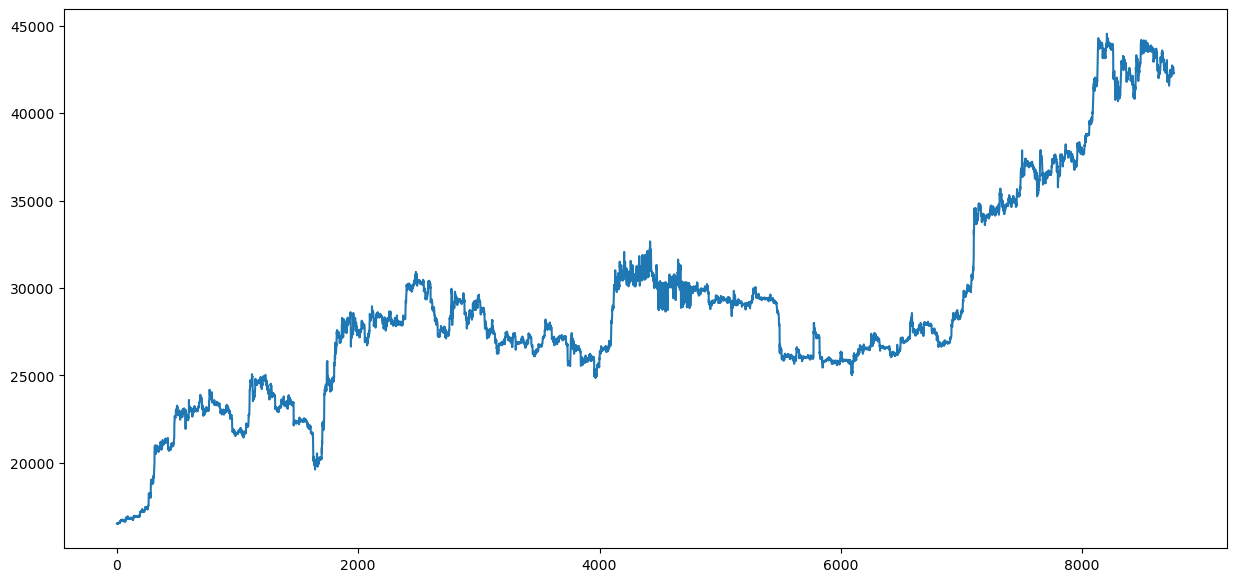

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(price.index, price['close'])
plt.show()

점차적으로 상승하는 그래프의 형태를 띄고 있다 부럽다


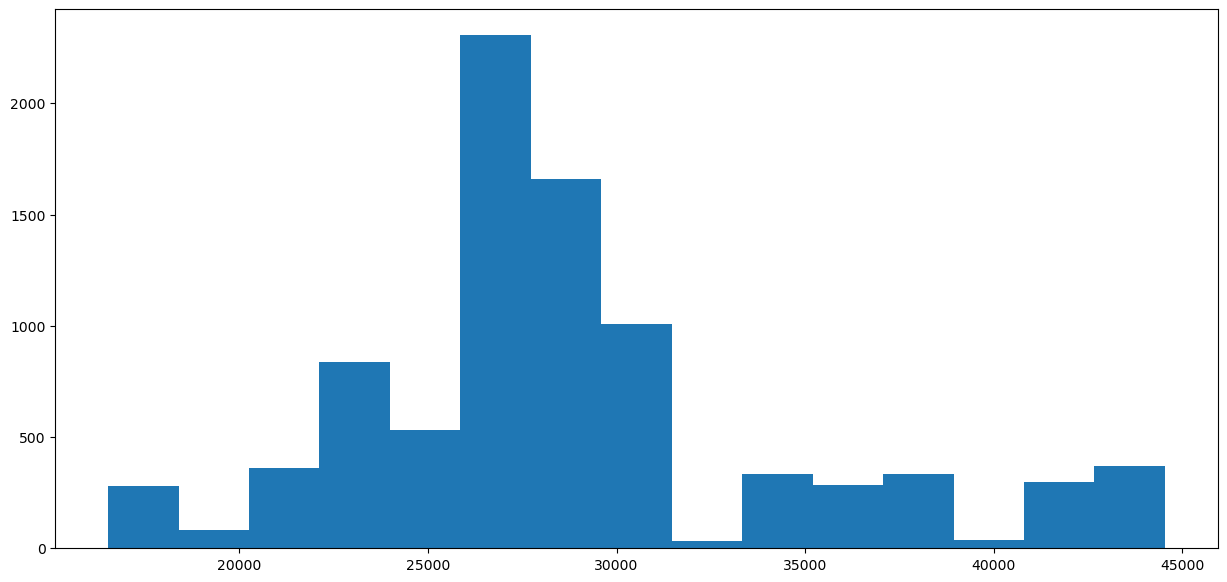

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.hist(price['close'], bins=15)
plt.show()

히스토그램의 의미는 별로 없는거 같다, 중위값인 27000 근처에 많이 몰려있는 것은 확인된다, 30000 초반에서 중반으로 확 뛰어서 중간 갭이 생겼다, 40000 근처도 마찬가지

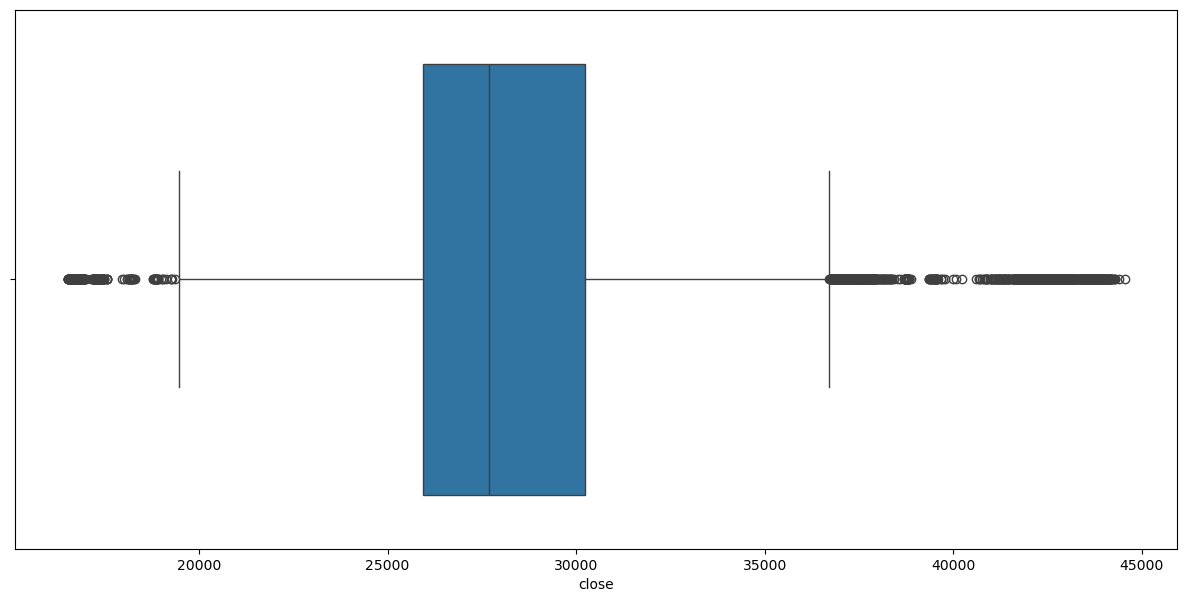

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.boxplot(x='close', data=price, ax=ax)
plt.show()

박스 플롯도 지속적으로 가격이 상승했기 때문에 분포가 넓고 아웃라이어가 많이 찍힌 듯 싶다, 나로서는 다른 인사이트를 생각해내지 못할거같다